In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/with_cloudy/train_B_over_ganaug_025"
plot_title = "train_B_over_ganaug_025"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.745215,0.7465,0.629482,0.7465,0.912722,0.869739,0.803088,0.701460,0.550035
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.802262,0.8050,0.721543,0.8050,0.938529,0.904984,0.856539,0.772725,0.649572
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.809843,0.8115,0.731491,0.8115,0.944311,0.917702,0.869437,0.794894,0.662619
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.817918,0.8210,0.742759,0.8210,0.948285,0.923620,0.878044,0.807198,0.677397
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.820065,0.8230,0.745574,0.8230,0.950557,0.926748,0.882935,0.813383,0.681170


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.757492,0.7575,0.649082,0.7575,0.913899,0.871367,0.799759,0.694427,0.570895
1,2,test,0.800993,0.8030,0.707730,0.8030,0.940217,0.906573,0.857208,0.766902,0.647103
2,3,test,0.822370,0.8225,0.742894,0.8225,0.947818,0.920114,0.874460,0.796260,0.685433
3,4,test,0.830732,0.8320,0.752837,0.8320,0.951595,0.925397,0.884033,0.812147,0.700000
4,5,test,0.835663,0.8365,0.759774,0.8365,0.953646,0.927685,0.888752,0.818952,0.708742


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/337:,Train,Loss,=,1.639,Valid,Loss,=,1.610,ETA,=,5.66h
1,Epoch,"1/40,",Batch,20/337:,Train,Loss,=,1.548,Valid,Loss,=,1.587,ETA,=,5.07h
2,Epoch,"1/40,",Batch,30/337:,Train,Loss,=,1.511,Valid,Loss,=,1.490,ETA,=,4.75h
3,Epoch,"1/40,",Batch,40/337:,Train,Loss,=,1.470,Valid,Loss,=,1.469,ETA,=,4.11h
4,Epoch,"1/40,",Batch,50/337:,Train,Loss,=,1.453,Valid,Loss,=,1.409,ETA,=,4.30h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.639,1.610
20,1,20,1.548,1.587
30,1,30,1.511,1.490
40,1,40,1.470,1.469
50,1,50,1.453,1.409


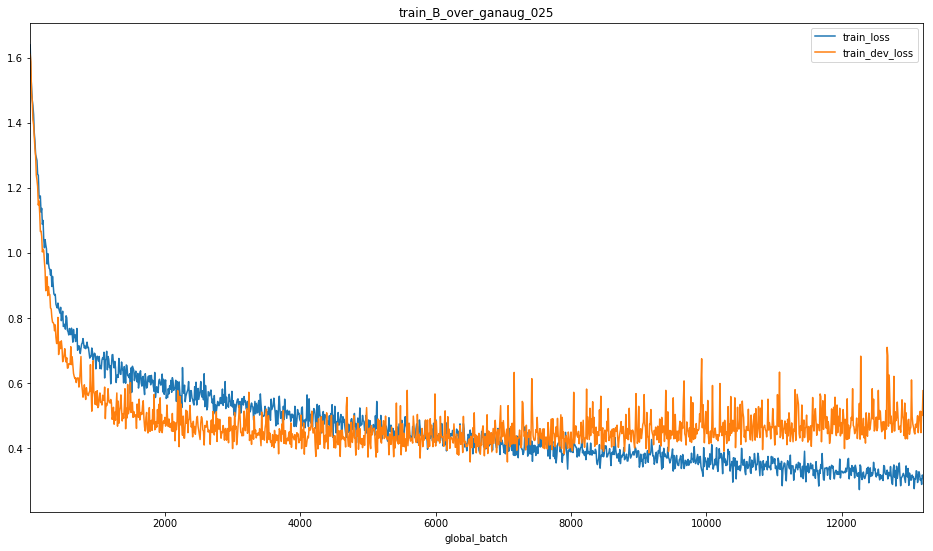

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.137,1.066
2,0.801,0.688
3,0.708,0.579
4,0.667,0.539
5,0.628,0.511


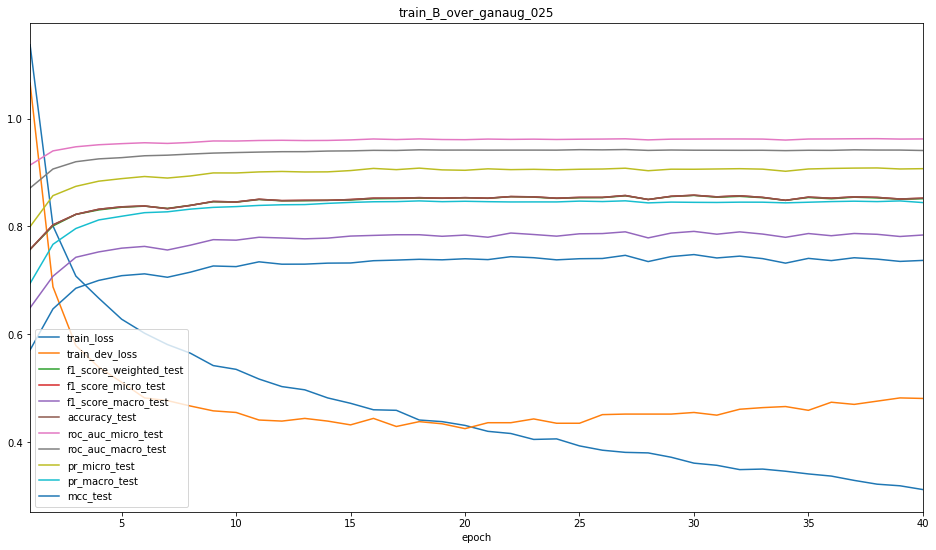

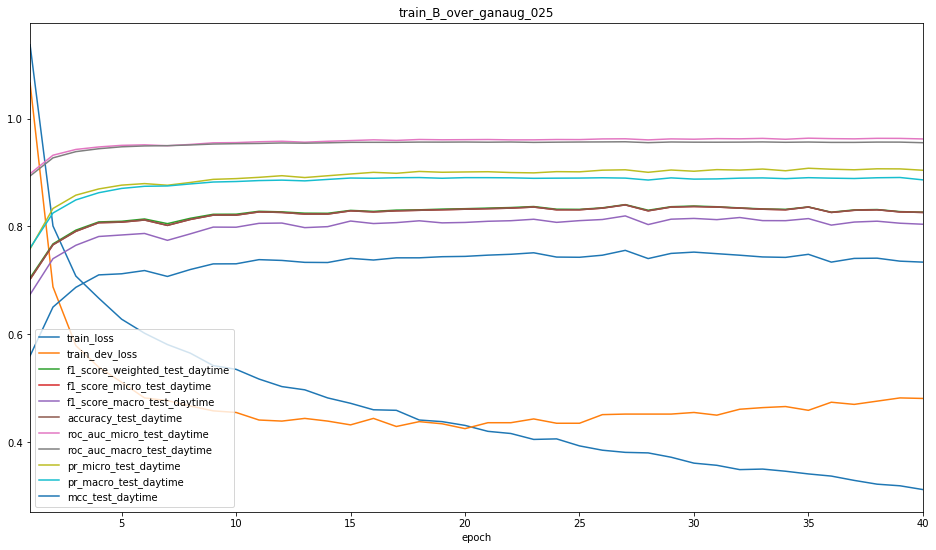

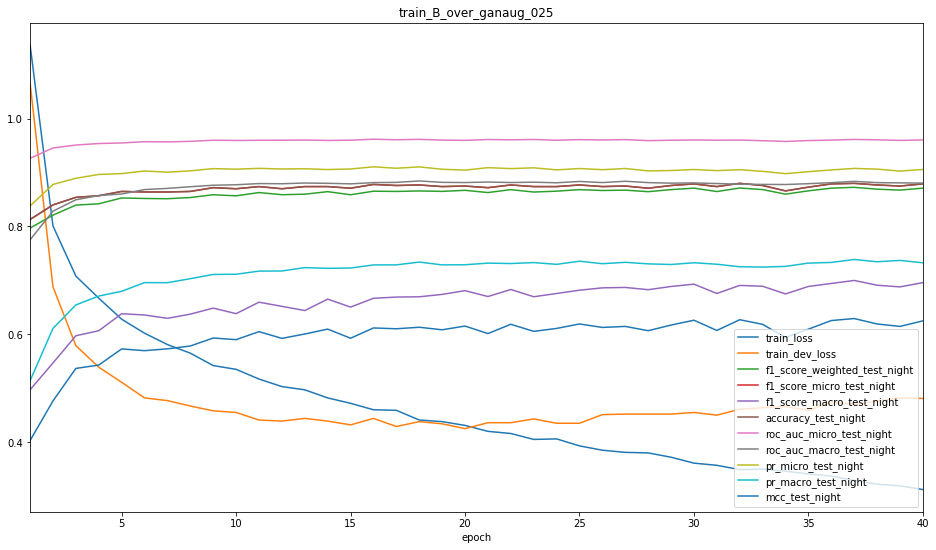

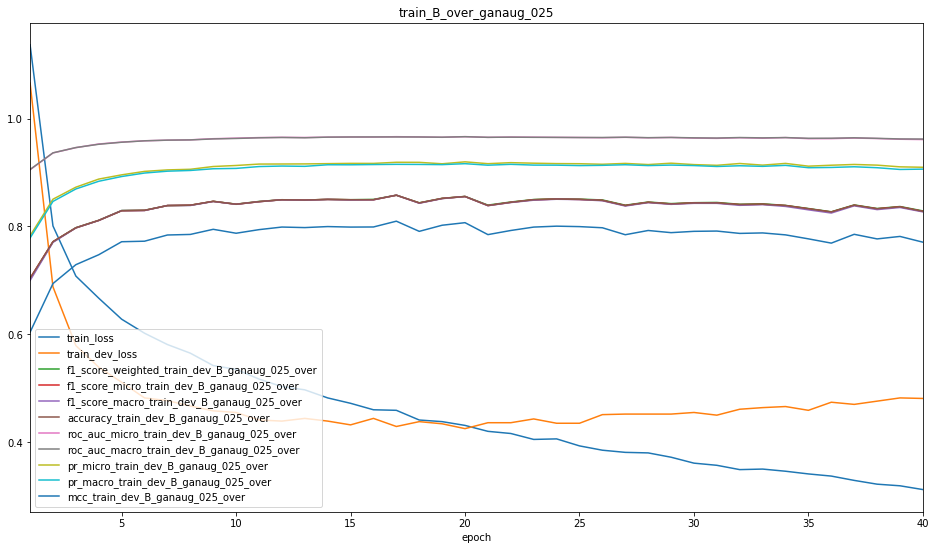

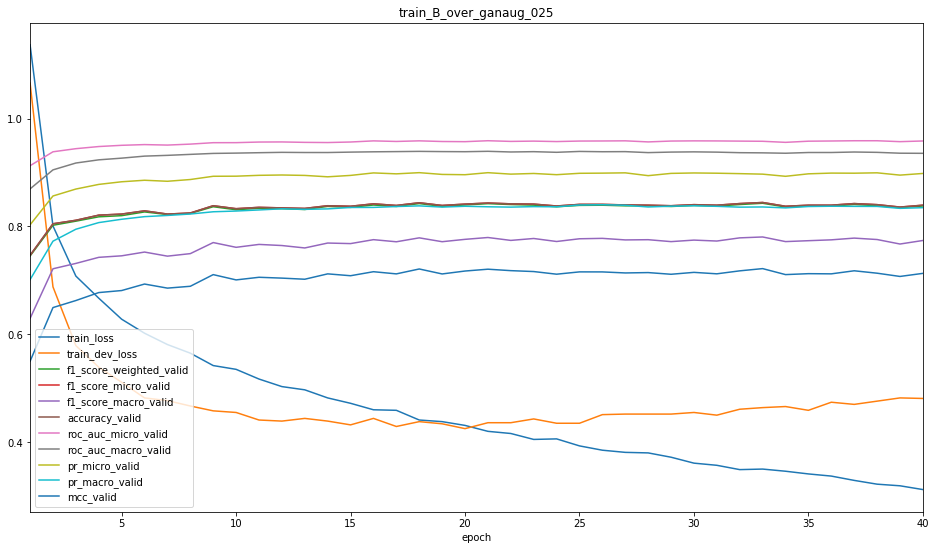

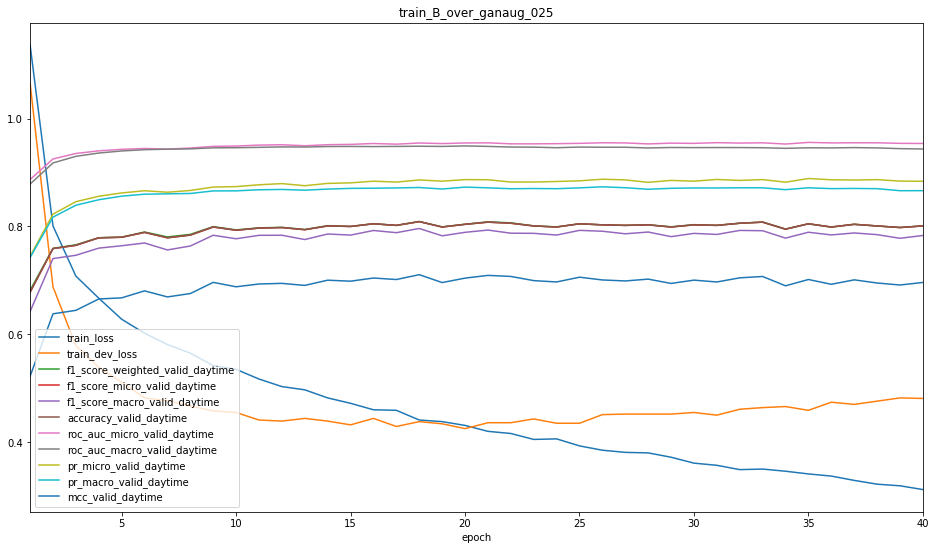

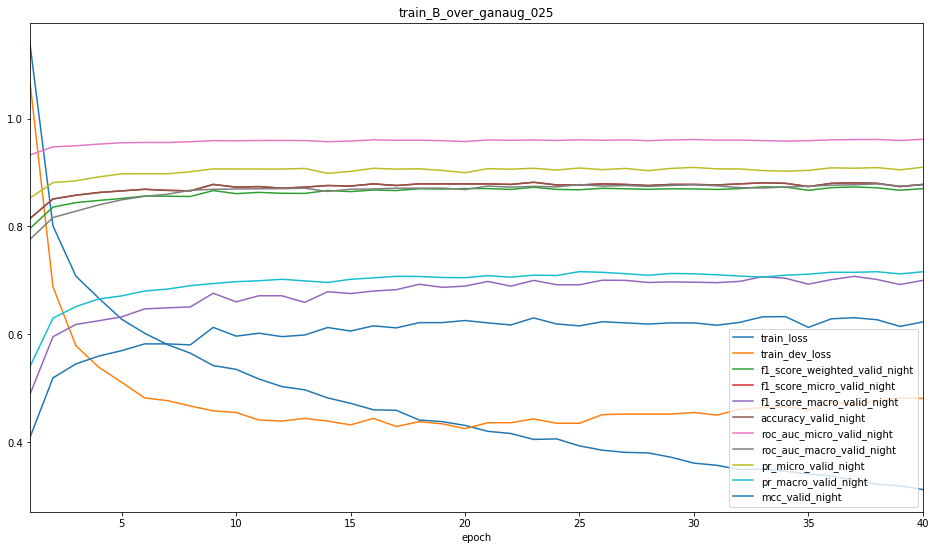

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)